In [5]:
%load_ext autoreload
%autoreload 2

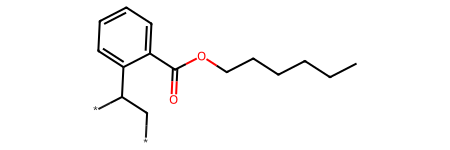

In [6]:
import pandas as pd
full_train_data = pd.read_csv("../data/train.csv")
valid_ffv = full_train_data[full_train_data['FFV'].notna()]

two_star_ffv = valid_ffv[valid_ffv['SMILES'].str.count(r"\*") == 2]

from data_gen_helpers import display_smiles
sample_smiles = two_star_ffv.loc[0, 'SMILES']

display_smiles(sample_smiles)

In [7]:
import pickle
import gzip

if 'matching_dataset' not in locals():
    matching_dataset = []
if not matching_dataset:
    file_path = "../data/vae_github_data/dataset_train_fc.pkl.gz"
    with gzip.open(file_path, "rb") as f:
        matching_dataset = pickle.load(f)

print(type(matching_dataset[0]))
print(matching_dataset[0]['x'])
print(matching_dataset[0]['edge_index'])

<class 'torch_geometric.data.data.Data'>
tensor([[ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  0,  1,  0,  0],
        [ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  0,  1,  0,  0],
        [ 1,  0,  0,  1,  0,  0],
        [ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  0,  1,  0,  0],
        [-1,  0,  1,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
       

In [8]:
from dataset_helpers import *

print(minimal_orbital_token(24))
print(minimal_orbital_token(46))
print(minimal_orbital_token(113))
print(minimal_orbital_token(6))
print(minimal_orbital_token(1, include_star_dim=True))  # Hydrogen
print(minimal_orbital_token(-4, include_star_dim=True))

tensor([4., 1., 4., 5., 0.])
tensor([ 5.,  0.,  6., 10.,  0.])
tensor([ 7.,  2.,  1., 10., 14.])
tensor([2., 2., 2., 0., 0.])
tensor([1., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1.])


In [9]:
two_star_ffv_graph_data = smiles_iter_to_graph_dataset(two_star_ffv.SMILES, two_star_ffv.FFV)

save_dataset(two_star_ffv_graph_data, '../data/working_datasets/two_star_include_stars')

In [10]:
from torch.utils.data import random_split
from torch_geometric.loader import DataListLoader

TRAIN_TEST_RATIO = 0.9
train_len = int(TRAIN_TEST_RATIO* len(two_star_ffv_graph_data))
train_dataset, test_dataset = random_split(two_star_ffv_graph_data, [train_len, len(two_star_ffv_graph_data)-train_len])

train_dataloader = DataListLoader(train_dataset)
test_dataloader = DataListLoader(test_dataset)

print(train_dataset[0])
print(train_dataset[0]['x'])
print(train_dataset[0]['edge_attr'])
print(train_dataset[0]['edge_index'])

Data(x=[23, 6], edge_index=[2, 44], edge_attr=[44, 4], y=0.32618869)
tensor([[0., 0., 0., 0., 0., 1.],
        [2., 2., 2., 0., 0., 0.],
        [2., 2., 2., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [2., 2., 4., 0., 0., 0.],
        [2., 2., 2., 0., 0., 0.],
        [2., 2., 4., 0., 0., 0.],
        [2., 2., 2., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 2., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 2., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 2., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 2., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.],
        [2., 2., 5., 0., 0., 0.]])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0

In [11]:
from typing import List, Union, Tuple, Optional
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import (
    GINConv, 
    MessagePassing, 
    GATConv, 
    JumpingKnowledge,
)
from torch_geometric.utils import add_self_loops
from torch_geometric.nn.resolver import normalization_resolver, activation_resolver

from torch.nn import Linear, ModuleList

class CustomGINEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dims, out_channels, dropout=0.0, act='relu', act_kwargs={}, norm=None, norm_kwargs={}, jk="cat", **kwargs):
        super().__init__()

        self.supports_edge_weights=False
        self.supports_edge_attrs=True

        self.num_layers = len(hidden_dims)
        self.hidden_layers = list(hidden_dims)

        if len(self.hidden_layers) == 0:
            raise ValueError("Must have at least one layer")
        
        self.dropout = torch.nn.Dropout(p=dropout)
        self.act = activation_resolver(act, **act_kwargs)
        self.norm = norm
        self.in_channels = in_channels
        self.out_channels = out_channels

        di = [in_channels] + hidden_dims
        do = hidden_dims + [out_channels]

        self.convs = ModuleList()
        self.norms = ModuleList()

        for (in_dim, out_dim) in zip(di, do):
            self.convs.append(
                self.init_conv(in_dim, out_dim, **kwargs)
            )
            layer_norm = normalization_resolver(
                norm, out_dim, **norm_kwargs
            ) if norm is not None else nn.Identity()
            self.norms.append(layer_norm)

        self.jk_mode = jk
        self.jk = None
        if jk is not None and jk != 'last':
            self.jk = JumpingKnowledge(jk, hidden_dims[-1], len(hidden_dims)-1)
        
        if jk is not None:
            if jk == 'cat':
                in_channels = sum(do)
            else:
                in_channels = out_channels
            self.lin = Linear(in_channels, self.out_channels)

    def init_conv(self, 
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int, **kwargs) -> MessagePassing:
        # GAN attentions conv, supports node and edge weight
        return GATConv(in_channels, out_channels, heads=6, concat=False, dropout=self.dropout.p)

    def forward( 
        self,
        data,
        batch: Optional[Tensor] = None
    ):
        x=data.x
        
        edge_index=data.edge_index
        if data.edge_attr is None:
            edge_attr=data.edge_weight
            edge_weight=data.edge_weight
        else:
            edge_attr=data.edge_attr
            edge_weight=data.edge_attr
        if data.batch is not None:
            batch=data.batch
            
        xs: List[Tensor] = []
        for i, (conv, norm) in enumerate(zip(self.convs, self.norms)):

            if self.supports_edge_weights and self.supports_edge_attrs:
                x = conv(x, edge_index, edge_weight=edge_weight,
                    edge_attr=edge_attr)
            elif self.supports_edge_weights:
                x = conv(x, edge_index, edge_weight)
            elif self.supports_edge_attrs:
                x = conv(x, edge_index, edge_attr=edge_attr)
            else:
                x = conv(x, edge_index)

            if i < self.num_layers or self.jk_mode is not None:

                if self.norm in ["instance","pairnorm","layer","graph"]:
                    x = norm(x, batch)
                else:
                    x = norm(x)

                if self.act is not None:
                    x = self.act(x)
                x = self.dropout(x)

                if self.jk is not None:
                    xs.append(x)

        # if self.jk_mode is not None:
        #     xj = self.jk(xs)
        #     return self.lin(xj)
        
        return x
        

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.nn import GATConv
from torch_geometric.nn.models import InnerProductDecoder
from torch_geometric.utils import (
    add_self_loops, remove_self_loops, dropout_edge, 
    coalesce, negative_sampling, to_undirected
)
from torch_geometric.data import Data, Batch
import torch_geometric.utils as utils


class DualGraphRecurrentModule(nn.Module):
    """
    Recurrent module that processes two sets of graph data as one combined graph,
    but only outputs results for the second graph using the first set of edges.
    """
    def __init__(self, in_channels: int, hidden_dim: int = 64, num_attention_layers: int = 3, 
                 heads: int = 4, dropout: float = 0.1):
        super(DualGraphRecurrentModule, self).__init__()
        
        self.num_attention_layers = num_attention_layers
        self.edge_dropout_prob = dropout
        self.attention_layers = nn.ModuleList()
        
        # First layer: in_channels -> hidden_dim
        self.attention_layers.append(
            GATConv(in_channels, hidden_dim, heads=heads, concat=False, dropout=dropout)
        )
        
        # Intermediate layers: hidden_dim -> hidden_dim
        for _ in range(num_attention_layers - 2):
            self.attention_layers.append(
                GATConv(hidden_dim, hidden_dim, heads=heads, concat=False, dropout=dropout)
            )
        
        # Last layer: hidden_dim -> in_channels (to maintain shape)
        if num_attention_layers > 1:
            self.attention_layers.append(
                GATConv(hidden_dim, in_channels, heads=heads, concat=False, dropout=dropout)
            )
        else:
            # If only one layer, output in_channels directly
            self.attention_layers[0] = GATConv(in_channels, in_channels, heads=heads, concat=False, dropout=dropout)
        
        self.final_attention = GATConv(in_channels, in_channels, heads=heads, concat=False, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.residual = nn.Linear(in_channels, in_channels) if num_attention_layers > 0 else nn.Identity()
        
        # Edge manipulation layer
        self.edge_manipulator = EdgeManipulationLayer(dropout)
        
    def forward(self, x1: Tensor, x2: Tensor, edge_index1: Tensor, edge_index2: Tensor) -> Tensor:
        """
        Combine both graphs into one large graph, apply convolutions, then return only second graph results.
        
        Args:
            x1: Node features of first graph [num_nodes1, in_channels]
            x2: Node features of second graph [num_nodes2, in_channels]
            edge_index1: Edge connectivity of first graph [2, num_edges1]
            edge_index2: Edge connectivity of second graph [2, num_edges2]
            
        Returns:
            Updated and normalized node features for second graph [num_nodes2, in_channels]
        """
        num_nodes1, num_nodes2 = x1.size(0), x2.size(0)
        
        # Combine node features
        x_combined = torch.cat([x1, x2], dim=0)  # [num_nodes1 + num_nodes2, in_channels]
        
        # Offset edge indices for second graph to account for combined graph
        edge_index2_offset = edge_index2 + num_nodes1
        
        # Apply edge manipulation to first set of edges, but ensure they're valid for second graph
        # We need to adjust edge_index1 to point to nodes in the second graph
        edge_index1_for_second = self.edge_manipulator(
            edge_index1, num_nodes2, offset=num_nodes1
        )
        
        # Combine all edges into one large graph
        edge_index_combined = torch.cat([edge_index1, edge_index2_offset, edge_index1_for_second], dim=1)
        
        # Remove duplicates and ensure valid connectivity
        edge_index_combined = coalesce(edge_index_combined, num_nodes=num_nodes1 + num_nodes2)
        
        residual = self.residual(x2)
        
        # Process combined graph (no gradients for intermediate layers)
        with torch.no_grad():
            h_combined = x_combined
            for attention_layer in self.attention_layers:
                h_combined = attention_layer(h_combined, edge_index_combined)
                h_combined = F.relu(h_combined)
                h_combined = self.dropout(h_combined)
        
        # Final attention with gradients (only extract second graph portion)
        h_combined = self.final_attention(h_combined, edge_index_combined)
        h2_output = h_combined[num_nodes1:num_nodes1 + num_nodes2]  # Extract second graph nodes
        
        # Normalize the output
        h2_normalized = F.normalize(h2_output, p=2, dim=1)
        
        # Add residual connection
        output = h2_normalized + residual
        
        return output


class EdgePredictionModule(nn.Module):
    """
    Module that uses PyG's InnerProductDecoder for proper edge prediction.
    Includes edge manipulation capabilities using PyG utilities.
    """
    def __init__(self, in_channels: int, hidden_dim: int = 64, 
                 edge_threshold: float = 0.5, edge_dropout_prob: float = 0.1):
        super(EdgePredictionModule, self).__init__()
        
        self.edge_threshold = edge_threshold
        self.hidden_dim = hidden_dim
        
        # Node encoder to create embeddings for edge prediction
        self.gat1 = GATConv(in_channels, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
        
        # Use PyG's InnerProductDecoder for edge prediction
        self.decoder = InnerProductDecoder()
        
        # Edge manipulation layer
        self.edge_manipulator = EdgeManipulationLayer(edge_dropout_prob)
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        """
        Predict new edges using PyG's proper edge prediction pipeline.
        
        Args:
            x: Node features [num_nodes, in_channels]
            edge_index: Existing edge connectivity [2, num_edges]
            
        Returns:
            New edge_index [2, num_new_edges]
        """
        num_nodes = x.size(0)
        
        # Apply edge manipulation to input edges
        edge_index_modified = self.edge_manipulator(edge_index, num_nodes)
        
        # Create node embeddings using the encoder
        z = self.gat1(x, edge_index_modified)  # [num_nodes, hidden_dim]
        z = self.relu(z)
        z = self.dropout(z)
        z = self.gat2(z, edge_index_modified)
        z = self.relu(z)
        
        # Generate all possible node pairs for edge prediction
        row, col = torch.meshgrid(
            torch.arange(num_nodes, device=x.device),
            torch.arange(num_nodes, device=x.device),
            indexing='ij'
        )
        
        # Create edge index for all possible edges (excluding self-loops)
        mask = row != col
        all_edges = torch.stack([row[mask], col[mask]], dim=0)
        
        # Use InnerProductDecoder to predict edge probabilities
        edge_probs = self.decoder(z, all_edges, sigmoid=True)  # [num_possible_edges]
        
        # Select edges above threshold
        selected_mask = edge_probs > self.edge_threshold
        new_edge_index = all_edges[:, selected_mask]
        
        # Ensure edges are undirected
        new_edge_index = to_undirected(new_edge_index, num_nodes=num_nodes)
        
        return new_edge_index


class EdgeManipulationLayer(nn.Module):
    """
    Layer that uses PyG utilities for proper edge manipulation (add/remove/dropout).
    """
    def __init__(self, dropout_prob: float = 0.1):
        super(EdgeManipulationLayer, self).__init__()
        
        self.dropout_prob = dropout_prob
        
    def forward(self, edge_index: Tensor, num_nodes: int, offset: int = 0) -> Tensor:
        """
        Apply edge manipulation using PyG utilities.
        
        Args:
            edge_index: Current edge connectivity [2, num_edges]
            num_nodes: Number of nodes in the target graph
            offset: Offset to add to edge indices (for graph combination)
            
        Returns:
            Modified edge_index [2, num_modified_edges]
        """
        if not self.training:
            # Apply offset if specified
            if offset > 0:
                edge_index = edge_index + offset
                # Ensure edges are within valid range
                valid_mask = (edge_index[0] < offset + num_nodes) & (edge_index[1] < offset + num_nodes)
                edge_index = edge_index[:, valid_mask]
            return edge_index
        
        # Apply edge dropout using PyG utility
        edge_index, _ = dropout_edge(
            edge_index, 
            p=self.dropout_prob, 
            force_undirected=True,
            training=self.training
        )
        
        # Apply offset if specified
        if offset > 0:
            edge_index = edge_index + offset
            # Ensure edges are within valid range after offset
            valid_mask = (edge_index[0] < offset + num_nodes) & (edge_index[1] < offset + num_nodes)
            edge_index = edge_index[:, valid_mask]
        
        # Optional: Add some random edges (edge addition)
        if torch.rand(1).item() < self.dropout_prob:
            num_new_edges = max(1, int(edge_index.size(1) * 0.1))  # Add 10% more edges
            
            if offset > 0:
                # For offset case, add edges within the target range
                new_source = torch.randint(offset, offset + num_nodes, (num_new_edges,), device=edge_index.device)
                new_target = torch.randint(offset, offset + num_nodes, (num_new_edges,), device=edge_index.device)
            else:
                new_source = torch.randint(0, num_nodes, (num_new_edges,), device=edge_index.device)
                new_target = torch.randint(0, num_nodes, (num_new_edges,), device=edge_index.device)
            
            # Remove self-loops from new edges
            valid_new = new_source != new_target
            if valid_new.any():
                new_edges = torch.stack([new_source[valid_new], new_target[valid_new]], dim=0)
                edge_index = torch.cat([edge_index, new_edges], dim=1)
        
        # Remove duplicates and ensure proper format
        edge_index = coalesce(edge_index, num_nodes=offset + num_nodes if offset > 0 else num_nodes)
        
        return edge_index

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import InnerProductDecoder, GATConv, global_mean_pool, global_max_pool
from torch_geometric.nn.resolver import activation_resolver
from torch import Tensor
from typing import Optional, Union


class PolicyModule(nn.Module):
    """
    Policy module that determines whether to continue (0) or stop (1) the recurrent process.
    Acts like a VGAE by encoding the graph and making a binary decision.
    """
    def __init__(self, in_channels: int, hidden_dim: int = 64, dropout: float = 0.1):
        super(PolicyModule, self).__init__()
        
        # Graph attention for encoding
        self.gat1 = GATConv(in_channels, hidden_dim, heads=4, concat=False, dropout=dropout)
        self.gat2 = GATConv(hidden_dim, hidden_dim // 2, heads=2, concat=False, dropout=dropout)
        
        # Policy decision layers
        self.continue_fc = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid()
        )

        # Policy decision layers
        self.halt_fc = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid()
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: Tensor, edge_index: Tensor, batch: Optional[Tensor] = None) -> tuple:
        """
        Forward pass of policy module.
        
        Args:
            x: Node features [num_nodes, in_channels]
            edge_index: Edge connectivity [2, num_edges]
            batch: Batch indices [num_nodes] for batched graphs
            
        Returns:
            policy_decision: Binary decision (0=continue, 1=stop) [batch_size, 1]
            reconstructed: Reconstructed node features [num_nodes, in_channels]
        """
        # Encode graph
        h1 = F.relu(self.gat1(x, edge_index))
        h1 = self.dropout(h1)
        h2 = F.relu(self.gat2(h1, edge_index))
        h2 = self.dropout(h2)
        
        # Pool to graph-level representation for policy decision
        if batch is not None:
            graph_embedding = global_mean_pool(h2, batch)
        else:
            graph_embedding = torch.mean(h2, dim=0, keepdim=True)
        
        # Policy decision (0 = continue, 1 = stop)
        continue_q_val = self.continue_fc(graph_embedding)
        halt_q_val = self.halt_fc(graph_embedding)
        
        return halt_q_val, continue_q_val


class RecurrentModule(nn.Module):
    """
    Recurrent module that applies attention convolution multiple times.
    """
    def __init__(self, in_channels: int, hidden_dim: int = 64, num_attention_layers: int = 3, 
                 heads: int = 4, dropout: float = 0.1):
        super(RecurrentModule, self).__init__()
        
        self.num_attention_layers = num_attention_layers
        self.attention_layers = nn.ModuleList()
        
        # First layer: in_channels -> hidden_dim
        self.attention_layers.append(
            GATConv(in_channels, hidden_dim, heads=heads, concat=False, dropout=dropout)
        )
        
        # Intermediate layers: hidden_dim -> hidden_dim
        for _ in range(num_attention_layers - 2):
            self.attention_layers.append(
                GATConv(hidden_dim, hidden_dim, heads=heads, concat=False, dropout=dropout)
            )
        
        # Last layer: hidden_dim -> in_channels (to maintain shape)
        if num_attention_layers > 1:
            self.attention_layers.append(
                GATConv(hidden_dim, in_channels, heads=heads, concat=False, dropout=dropout)
            )
        else:
            # If only one layer, output in_channels directly
            self.attention_layers[0] = GATConv(in_channels, in_channels, heads=heads, concat=False, dropout=dropout)
        
        self.final_attention = GATConv.GATConv(in_channels, in_channels, heads=heads, concat=False, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.residual = nn.Linear(in_channels, in_channels) if num_attention_layers > 0 else nn.Identity()
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        """
        Apply attention convolution layers recurrently.
        
        Args:
            x: Node features [num_nodes, in_channels]
            edge_index: Edge connectivity [2, num_edges]
            
        Returns:
            Updated node features [num_nodes, in_channels]
        """
        residual = self.residual(x)
        
        with torch.no_grad():
            h = x
            for i, attention_layer in enumerate(self.attention_layers):
                h = attention_layer(h, edge_index)
                h = F.relu(h)
                h = self.dropout(h)
        
        h = self.final_attention(h, edge_index)
        
        # Add residual connection
        return h + residual


class OutputModule(nn.Module):
    """
    Output module that pools, convolves, and produces a single scalar output.
    """
    def __init__(self, in_channels: int, pool_size: int = 32, hidden_layers: int = 2, 
                 hidden_dim: int = 64, act: str = 'relu', dropout: float = 0.1):
        super(OutputModule, self).__init__()
        
        self.pool_size = pool_size
        self.hidden_layers = hidden_layers
        
        # Adaptive pooling to fixed size
        self.adaptive_pool = nn.AdaptiveAvgPool1d(pool_size)
        
        # Convolution layers
        self.conv1 = nn.Conv1d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim // 2, kernel_size=3, padding=1)
        
        # Calculate flattened size after pooling and convolution
        conv_output_size = (hidden_dim // 2) * pool_size
        
        # Build fully connected layers
        self.fc_layers = nn.ModuleList()
        
        # First FC layer
        self.fc_layers.append(nn.Linear(conv_output_size, hidden_dim))
        
        # Hidden FC layers
        for _ in range(hidden_layers - 1):
            self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, 1)
        
        self.act = activation_resolver(act)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
    def forward(self, x: Tensor, batch: Optional[Tensor] = None) -> Tensor:
        """
        Process graph tensor through pooling, convolution, and FC layers.
        
        Args:
            x: Node features [num_nodes, in_channels]
            batch: Batch indices for handling multiple graphs
            
        Returns:
            Single scalar output [batch_size, 1]
        """
        if batch is not None:
            # Handle batched graphs
            batch_size = batch.max().item() + 1
            outputs = []
            
            for i in range(batch_size):
                mask = (batch == i)
                graph_x = x[mask]  # [num_nodes_in_graph, in_channels]
                
                # Process single graph
                single_output = self._process_single_graph(graph_x)
                outputs.append(single_output)
            
            return torch.stack(outputs)
        else:
            # Single graph
            return self._process_single_graph(x).unsqueeze(0)
    
    def _process_single_graph(self, x: Tensor) -> Tensor:
        """Process a single graph through the output pipeline."""
        # x: [num_nodes, in_channels]
        
        # Transpose for Conv1d: [in_channels, num_nodes]
        x = x.transpose(0, 1)
        
        # Adaptive pooling to fixed size: [in_channels, pool_size]
        x = self.adaptive_pool(x)
        
        # Convolution layers
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        
        # Flatten: [in_channels * pool_size]
        x = x.flatten()
        
        # Fully connected layers with normalization
        for fc_layer in self.fc_layers:
            x = fc_layer(x)
            x = self.layer_norm(x)
            x = self.act(x)
            x = self.dropout(x)
        
        # Output layer
        x = self.output_layer(x)
        
        return x


class RecurrentDecoder(nn.Module):
    """
    Recurrent decoder that processes graphs iteratively using a policy-guided approach.
    """
    def __init__(self, in_channels: int, hidden_layers: int = 2, act: str = 'relu', 
                 max_iter: int = 5, hidden_dim: int = 64, num_attention_layers: int = 3,
                 pool_size: int = 32, dropout: float = 0.1):
        super(RecurrentDecoder, self).__init__()
        
        self.base_decoder = InnerProductDecoder()
        self.max_iter = max_iter
        self.in_channels = in_channels
        
        # Initialize modules
        self.policy_module = PolicyModule(in_channels, hidden_dim, dropout)
        self.low_module = DualGraphRecurrentModule(in_channels, hidden_dim, num_attention_layers, 
                                              heads=4, dropout=dropout)
        self.high_module = EdgePredictionModule(in_channels, hidden_dim, 0.6, dropout)
        self.output_module = OutputModule(in_channels, pool_size, hidden_layers, 
                                        hidden_dim, act, dropout)
        
    def forward(self, z: List[Tensor], edge_indices: List[Tensor], batch: Optional[Tensor] = None, segment_number = 0) -> Tensor:
        """
        Forward pass through the recurrent decoder.
        
        Args:
            z: Node embeddings of x, z_l: [2, num_nodes, in_channels]
            edge_index: Edge connectivity of x, z_l: [2, 2, num_edges]
            batch: Batch indices for multiple graphs
            
        Returns:
            Final scalar output [batch_size, 1]
        """
        z_l = z[1]
        z_h_edge = edge_indices[1]

        with torch.no_grad():
            for i in range(max(self.max_iter-1, 0)):
                z_l = self.low_module(z[0], z_l, edge_indices[0], z_h_edge)
                z_h_edge = self.high_module(z_l, z_h_edge)
        
        z_l = self.low_module(z[0], z_l, edge_indices[0], z_h_edge)
        z_h_edge = self.high_module(z_l, z_h_edge)
        
        # Generate final output (fix to work as hrm with only zh as param)
        output = self.output_module(z_l, batch)
        
        # Policy decision: should we continue or stop?
        with torch.no_grad():
            halt_q_val, continue_q_val = self.policy_module(z_l, z_h_edge, batch)
        
        return z_l, z_h_edge, output, halt_q_val, continue_q_val

In [88]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional, List, Tuple, Dict


class SingleIterationACTLoss(nn.Module):
    """
    Single-iteration ACT Loss following the Q-learning formulation from the paper.
    
    Implements the proper ACT loss with Q-learning targets:
    - G_halt = 1{ŷ^m = y} (binary reward for correct prediction)  
    - G_continue = Q_halt^{m+1} if m < N_max, else Q_halt^{m+1}
    - Loss = LOSS(ŷ^m, y) + BINARYCROSSENTROPY(Q̂^m, Ĝ^m)
    """
    
    def __init__(self, 
        policy_weight: float = 1.0,
        output_weight: float = 1.0,
        max_segments: int = 5,
        prediction_threshold: float = 0.1
    ):
        """
        Args:
            policy_weight: Weight for Q-learning policy loss
            output_weight: Weight for main prediction loss
            max_segments: Maximum number of segments (N_max in paper)
            prediction_threshold: Threshold for determining prediction correctness
        """
        super(SingleIterationACTLoss, self).__init__()
        
        self.policy_weight = policy_weight
        self.output_weight = output_weight
        self.max_segments = max_segments
        self.prediction_threshold = prediction_threshold
        
        # Loss functions
        self.output_loss_fn = nn.MSELoss()  # Sequence-to-sequence loss
        self.q_loss_fn = nn.BCEWithLogitsLoss()  # Q-learning loss
        
    def forward(self, 
        q_halt: Tensor,                 # Q-value for halt action [batch_size, 1]
        q_continue: Tensor,             # Q-value for continue action [batch_size, 1]
        final_output: Tensor,          # Final prediction [batch_size, output_dim]
        targets: Tensor,               # Ground truth [batch_size, output_dim]
        current_segment: int,          # Current segment number (m in paper)
        next_q_values: Optional[Tensor] = None  # Q-values from next iteration (for G_continue)
        ) -> Tuple[Tensor, Dict]:
        """
        Compute single-iteration ACT losses following the paper's Q-learning formulation.
        
        Args:
            q_halt: Predicted Q-value for halt action
            q_continue: Predicted Q-value for continue action  
            recurrent_output: Output from recurrent module (will be detached for encoder loss)
            final_output: Final output from output module
            targets: Ground truth targets
            current_segment: Current segment number (m)
            next_q_values: Optional Q-values from next iteration [batch_size, 2] -> [Q_halt^{m+1}, Q_continue^{m+1}]
            
        Returns:
            policy_output_loss: Loss for policy + recurrent + output modules
            encoder_loss: Loss for encoder module (with detached recurrent output)
            loss_dict: Dictionary with loss components for monitoring
        """
        batch_size = targets.shape[0]
        
        # 1. Sequence-to-sequence loss: LOSS(ŷ^m, y)
        output_loss = self.output_loss_fn(final_output, targets)
        
        # 2. Compute Q-learning targets following ACT paper
        with torch.no_grad():
            # G_halt^m = 1{ŷ^m = y} - binary reward for correct prediction
            if targets.dtype == torch.float:
                # For regression: use threshold-based correctness
                prediction_correct = (torch.abs(final_output - targets).mean(dim=1, keepdim=True) 
                    < self.prediction_threshold).float()
            else:
                # For classification: exact match
                prediction_correct = (final_output.argmax(dim=-1, keepdim=True) == targets).float()
            
            g_halt = prediction_correct  # [batch_size, 1]
            
            # G_continue^m computation
            if current_segment >= self.max_segments:
                # If m >= N_max: G_continue^m = Q_halt^{m+1} = G_halt^m (terminal)
                g_continue = g_halt
            else:
                # Otherwise: G_continue^m = max(Q_halt^{m+1}, Q_continue^{m+1})
                if next_q_values is not None:
                    # Use actual next Q-values if provided
                    next_q_halt, next_q_continue = next_q_values[:, 0:1], next_q_values[:, 1:2]
                    g_continue = torch.max(next_q_halt, next_q_continue)
                else:
                    # Estimate using current values (approximation for single iteration)
                    g_continue = torch.max(g_halt, torch.zeros_like(g_halt))
            
            # Combined Q-targets: Ĝ^m = (G_halt^m, G_continue^m)
            q_targets_halt = g_halt
            q_targets_continue = g_continue
        
        # 3. Q-learning loss: BINARYCROSSENTROPY(Q̂^m, Ĝ^m)
        q_loss_halt = self.q_loss_fn(q_halt, q_targets_halt)
        q_loss_continue = self.q_loss_fn(q_continue, q_targets_continue)
        q_loss = q_loss_halt + q_loss_continue
        
        # 4. Combined ACT loss: L_ACT^m = LOSS(ŷ^m, y) + BINARYCROSSENTROPY(Q̂^m, Ĝ^m)
        policy_output_loss = self.output_weight * output_loss + self.policy_weight * q_loss
     
        # 6. SAFER: Create loss_dict without .item() calls during gradient computation
        loss_dict = {
            'policy_output_loss': policy_output_loss.detach().item(),
            'output_loss': output_loss.detach().item(),
            'q_loss': q_loss.detach().item(),
            'q_loss_halt': q_loss_halt.detach().item(),
            'q_loss_continue': q_loss_continue.detach().item(),
            'avg_g_halt': g_halt.mean().item(),
            'avg_g_continue': g_continue.mean().item(),
            'avg_q_halt': q_halt.detach().mean().item(),
            'avg_q_continue': q_continue.detach().mean().item()
        }
        
        return policy_output_loss, loss_dict
    


In [ ]:
# Import models from the new models.py file
from models import (
    CustomGINEncoder,
    DualGraphRecurrentModule,
    EdgePredictionModule,
    EdgeManipulationLayer,
    PolicyModule,
    RecurrentModule,
    OutputModule,
    RecurrentDecoder,
    SingleIterationACTLoss
)


In [ ]:
import torch
from torch_geometric.nn import Set2Set, AttentionalAggregation, GIN, VGAE, InnerProductDecoder
# from torch_geometric.nn.models.gpse import GPSE
from torch_geometric.transforms import add_positional_encoding

from torch_geometric.utils import negative_sampling, dropout_edge, dropout_node, from_smiles, to_smiles, to_rdmol, from_rdmol
from torch.optim import Adam
from torch.nn import SmoothL1Loss

config = {
    "epochs": 100,
    "batch_size": 64,

    "dropout": 0.01,
    "lr": 1e-5,
    "latent_dim": 50,

    "alpha": 0.1,
    "beta": 0.001,

    "segments": 5,

    "encoder": {
        "hidden_dims": [16, 32, 64],
        "output_dim": 128,
        "layers": 4,
        "norm": "layer"
    },

    "decoder": {
        "norm": "layer",
        "attention_heads": 2,
        "hidden_dim": 64,
        "decoder_layers": 3,
        
        # RecurrentDecoder specific parameters
        "in_channels": 128,  # Same as encoder output_dim
        "hidden_layers": 3,  # Number of hidden FC layers in output module
        "act": "relu",       # Activation function
        "max_iter": 5,       # Maximum recurrent iterations
        "num_attention_layers": 4,  # Attention layers in recurrent module
        "pool_size": 32,     # Pooling size for output module
        "policy_hidden_dim": 64,  # Hidden dimension for policy module
        "heads": 4,          # Attention heads for recurrent module
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

econfig=dict(config["encoder"])

encoder = CustomGINEncoder(
    in_channels=6, #length of 'x' data
    hidden_dims=econfig["hidden_dims"],
    out_channels=econfig["output_dim"],
    dropout=config["dropout"],
    act="leakyrelu",
    norm=econfig["norm"]
)
print("Encoder shape: ", encoder(train_dataset[0]).shape)

dconfig=dict(config["decoder"])
decoder = RecurrentDecoder(
    in_channels=dconfig["in_channels"],
    hidden_layers=dconfig["hidden_layers"],
    act=dconfig["act"],
    max_iter=dconfig["max_iter"],
    hidden_dim=dconfig["hidden_dim"],
    num_attention_layers=dconfig["num_attention_layers"],
    pool_size=dconfig["pool_size"],
    dropout=config["dropout"]
)

encoder_loss = SmoothL1Loss()
decoder_loss = SingleIterationACTLoss(policy_weight=0.5, max_segments=config["segments"], prediction_threshold=0.01)

encoder_opt = Adam(encoder.parameters())
output_opt = Adam(decoder.parameters())

x = encoder(train_dataset[0])
x_edg = train_dataset[0]['edge_index']

z_l, z_h_edge, pred, _, _ = decoder([x, x.detach()], [x_edg, torch.zeros_like(x_edg)])
print(pred.shape)
print(pred[0])


Encoder shape:  torch.Size([23, 128])
torch.Size([1, 1])
tensor([0.3883], grad_fn=<SelectBackward0>)


In [ ]:
from torch_geometric.data import Batch
torch.autograd.set_detect_anomaly(True)

def single_iter_train(data_batch):
    
    x: torch.Tensor = encoder(data_batch)
    x_edge = data_batch['edge_index']

    z_l = x.clone().detach()
    z_h_edge = torch.zeros_like(x_edge)

    for idx in range(0, config["segments"]):
        # Forward pass
        z_l, z_h_edge, y, halt_q, cont_q = decoder(
            [x, z_l], [x_edge, z_h_edge], segment_number=idx
        )

        with torch.no_grad():
            g_halt, g_cont = decoder.policy_module(z_l, z_h_edge)
        loss, dictionary_loss = decoder_loss(
            halt_q, 
            cont_q,
            y,
            data_batch["y"], 
            idx
        )
        
        loss.backward(retain_graph=True)
        output_opt.step()
        output_opt.zero_grad()
    
    # encoder_loss(x,)
    encoder_opt.zero_grad()


for batch in train_dataloader:
    print(batch)
    batch = Batch.from_data_list(batch)
    single_iter_train(batch)
    
    break



[Data(x=[23, 6], edge_index=[2, 44], edge_attr=[44, 4], y=0.32618869)]


/home/thomaspugh/projects/chem-properties/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
